In [8]:
!python3 -m pip install torch torchvision torchaudio scikit-learn opencv-python unet segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.2/432.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
"""
Created on Aug 04 2025

@author: vigo
"""
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np 
import cv2 as cv

import re
import glob

from unet import UNet
from segmentation_models_pytorch import UnetPlusPlus, PSPNet

torch.cuda.empty_cache()

NET_INPUT_SIZE = (576, 576)
NET_OUTPUT_SIZE = (576, 576)

def Normalize(img):
    return np.array(img/255.0, dtype=np.float32)

def Shape_Process(img):
    if img.shape > NET_INPUT_SIZE:
        img = cv.resize(img, NET_INPUT_SIZE, interpolation = cv.INTER_CUBIC)   # image reduction
        
    elif img.shape < NET_INPUT_SIZE:
        if img.shape[0] % 2:
            img = cv.resize(img, img.shape[0] // 2, interpolation = cv.INTER_CUBIC)
        padd = int((NET_INPUT_SIZE[0] - img.shape[0]) / 2)
        img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)
        
    return img

def Center_Crop(img):
    img = Shape_Process(img)
    crop_yx = (int((img.shape[0] - NET_OUTPUT_SIZE[0]) / 2), int((img.shape[1] - NET_OUTPUT_SIZE[1]) / 2))
    img = img[crop_yx[0]: crop_yx[0] + NET_OUTPUT_SIZE[0], crop_yx[1]: crop_yx[1] + NET_OUTPUT_SIZE[1]]
    
    return img

def Numerical_Sort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def Read_Images_Test(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis, np.newaxis]    # format => [N, H, W, C1, C2]
    return images

def Read_Images_Train(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
    
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return images

def Read_Images_GTruth(folder_path, image_names):
    labels = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        mask = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        mask = Center_Crop(mask)
        mask = Normalize(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        labels.append(mask)
    
    labels = np.asarray(labels, dtype=np.float32)
    labels = labels[:, :, :, np.newaxis]    # format => [N, H, W, C]
    return labels

def Matplotlib_Imshow(img):
    npimg = img.cpu().detach().numpy()
    npimg = (npimg * 255.0).astype("int")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

#%% dataset load and preprocessing

drive_path = "./data" 

test_images_path = drive_path + "/test/*.tif"

train_gtruth_path = drive_path + "/train/labels/*.tif"
train_images_path = drive_path + "/train/images/*.tif"

test_images = []
image_names = []
train_gtruth = []
train_images = []
test_images = Read_Images_Test(test_images_path, image_names)
train_images = Read_Images_Train(train_images_path, image_names)    
train_gtruth = Read_Images_GTruth(train_gtruth_path, image_names)

#%% Create data loaders.

device = 'cuda' if torch.cuda.is_available() else 'mps'
print(f'Using {device} device')

# pytorch input format => [N, H, W, C1] -> [N, C1, H, W]
train_tensor = torch.from_numpy(train_images).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
train_gtruth_tensor = torch.from_numpy(train_gtruth).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
# pytorch input format => [N, H, W, C1, C2] -> [N, C1, C2, H, W]
test_tensor = torch.from_numpy(test_images).transpose_(1 , 3).transpose_(2 , 4).float().to(device)

batch_size = 2
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
train_gtruth_dl = DataLoader(train_gtruth_tensor, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_tensor, batch_size = len(test_images), shuffle=False)
test_iter = next(iter(test_dl))

#%% create model
def get_pspnet_model():
    return PSPNet(
    encoder_name="resnet34",        # backbone
    encoder_weights=None,           # or "imagenet" if RGB
    in_channels=1,                  # you are loading grayscale images
    classes=1                       # binary segmentation
    )
    
model = get_pspnet_model().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 300

#%% train
for e in range(n_epochs):
    for i in range(len(train_dl)):
        train_iter = next(iter(train_dl))
        train_gtruth_iter = next(iter(train_gtruth_dl))
        optim.zero_grad()
        prediction = model(train_iter)
        loss = F.mse_loss(prediction, train_gtruth_iter)  # Try BCE, DICE loss 
        loss.backward()
        optim.step()
    print (f'Epoch--[{e+1}/{n_epochs}], Loss: {loss.item()}')

print('Finished Training')

#%% predict 
test_img_index = 0
test_prediction = model(test_iter[test_img_index])   

# show images
img_grid = make_grid(test_prediction)
Matplotlib_Imshow(img_grid)

#%% model save
torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

#%% model load
model_test = get_pspnet_model().to(device)
model_test.load_state_dict(torch.load("./model.pth"))

test_prediction = model_test(test_iter[0])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

Using mps device
Epoch--[1/300], Loss: 0.5954301953315735
Epoch--[2/300], Loss: 0.2011161595582962
Epoch--[3/300], Loss: 0.1832120269536972
Epoch--[4/300], Loss: 0.33665674924850464
Epoch--[5/300], Loss: 0.16197305917739868
Epoch--[6/300], Loss: 0.2530795931816101
Epoch--[7/300], Loss: 0.3327733278274536
Epoch--[8/300], Loss: 0.19968636333942413
Epoch--[9/300], Loss: 0.21957077085971832
Epoch--[10/300], Loss: 0.16620448231697083
Epoch--[11/300], Loss: 0.168975830078125
Epoch--[12/300], Loss: 0.27796152234077454
Epoch--[13/300], Loss: 0.1625547558069229
Epoch--[14/300], Loss: 0.19142232835292816
Epoch--[15/300], Loss: 0.18998929858207703
Epoch--[16/300], Loss: 0.16474536061286926
Epoch--[17/300], Loss: 0.14213456213474274
Epoch--[18/300], Loss: 0.1777859926223755
Epoch--[19/300], Loss: 0.3019009828567505
Epoch--[20/300], Loss: 0.17888055741786957
Epoch--[21/300], Loss: 0.16239136457443237
Epoch--[22/300], Loss: 0.13562150299549103
Epoch--[23/300], Loss: 0.2138703614473343
Epoch--[24/300

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


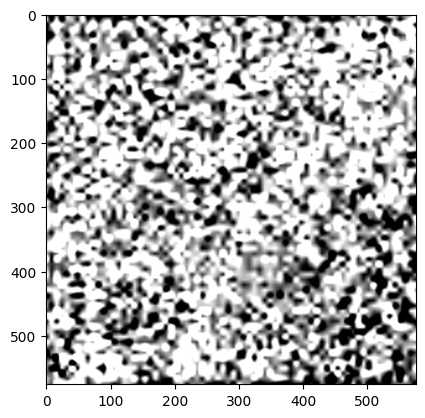

In [15]:
#%% model load
model_test = get_pspnet_model().to(device)
model_test.load_state_dict(torch.load("./model.pth"))

test_prediction = model_test(test_iter[0])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


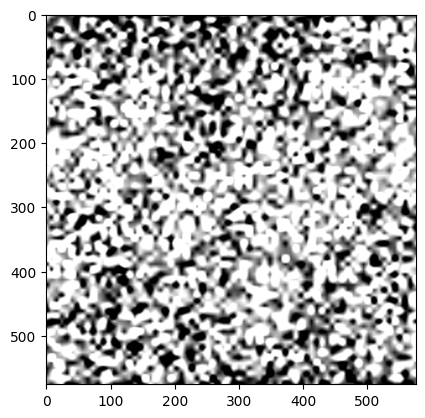

In [16]:
test_prediction = model_test(test_iter[7])
img_grid = make_grid(test_prediction)

# show images
Matplotlib_Imshow(img_grid)

In [17]:
print(loss.item())

0.4024825096130371


In [19]:
def metrics(preds, targets, threshold=0.5):
    if preds.max() > 1 or preds.min() < 0:
        preds = torch.sigmoid(preds)

    preds_bin = (preds > threshold).float()
    targets_bin = (targets > 0.5).float()

    preds_flat = preds_bin.view(-1)
    targets_flat = targets_bin.view(-1)

    TP = (preds_flat * targets_flat).sum().item()
    FP = (preds_flat * (1 - targets_flat)).sum().item()
    FN = ((1 - preds_flat) * targets_flat).sum().item()
    TN = ((1 - preds_flat) * (1 - targets_flat)).sum().item()

    # Metrics
    epsilon = 1e-7  # to avoid division by zero
    jaccard = TP / (TP + FP + FN + epsilon)
    f1_score = (2 * TP) / (2 * TP + FP + FN + epsilon)
    recall = TP / (TP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)

    return {
        "Jaccard": jaccard,
        "F1 Score": f1_score,
        "Recall": recall,
        "Precision": precision,
        "Accuracy": accuracy
    }

model_test.eval()
with torch.no_grad():
    train_preds = model(train_tensor)
    metrics = metrics(train_preds, train_gtruth_tensor)
    print(metrics)

{'Jaccard': 0.7728725167706275, 'F1 Score': 0.871887300930641, 'Recall': 0.9737763910758546, 'Precision': 0.7893004694743098, 'Accuracy': 0.7752677509323481}
